#### Outlier Engineering

An outlier is a data point which is significantly different from the remaining data. “An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Statistics such as the mean and variance are very susceptible to outliers. In addition, some Machine Learning models are sensitive to outliers which may decrease their performance. Thus, depending on which algorithm we wish to train, we often remove outliers from our variables.

We discussed in section 3 of this course how to identify outliers. In this section, we we discuss how we can process them to train our machine learning models.

**Preprocessing outliers:**

- Trimming: remove the outliers from our dataset
- Treat outliers as missing data, and proceed with any missing data imputation technique
- Discrestisation: outliers are placed in border bins together with higher or lower values of the distribution
- Censoring: capping the variable distribution at a max and / or minimum value

Censoring is AKA:
- top and bottom coding
- winsorization
- capping

##### Trimming or truncation

Trimming, also known as truncation, involves removing the outliers from the dataset. We only need to decide on a metric to determine outliers. As we saw in section 3, this can be the Gaussian approximation for normally distributed variables or the inter-quantile range proximity rule for skewed variables.

**Advantages**

- quick

**Limitations**

outliers for one variable could contain useful information in the other variables
if there are outliers across many variables, we could remove a big chunk of dataset

Dataset: House dataset

**Attention**

Outliers should be detected AND removed ONLY from the training set, and NOT from the test set.

So we should first divide our data set into train and tests, and remove outliers in the train set, but keep those in the test set, and measure how well our model is doing.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

# boston house dataset for the demo
from sklearn.datasets import load_boston

In [2]:
# load the the Boston House price data

# load the boston dataset from sklearn
boston_dataset = load_boston()
# create a dataframe with the independent variables
# I will use only 3 of the total variables for this demo
boston = pd.DataFrame(boston_dataset.data,columns=boston_dataset.feature_names)[['RM', 'LSTAT', 'CRIM']]
boston.head()

C:\Users\cssar\miniconda3\envs\whiskey_pt\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California 

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


In [5]:
# function to create histogram, Q-Q plot and
# boxplot. We learned this in section 3 of the course

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))
    print(variable)

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

RM


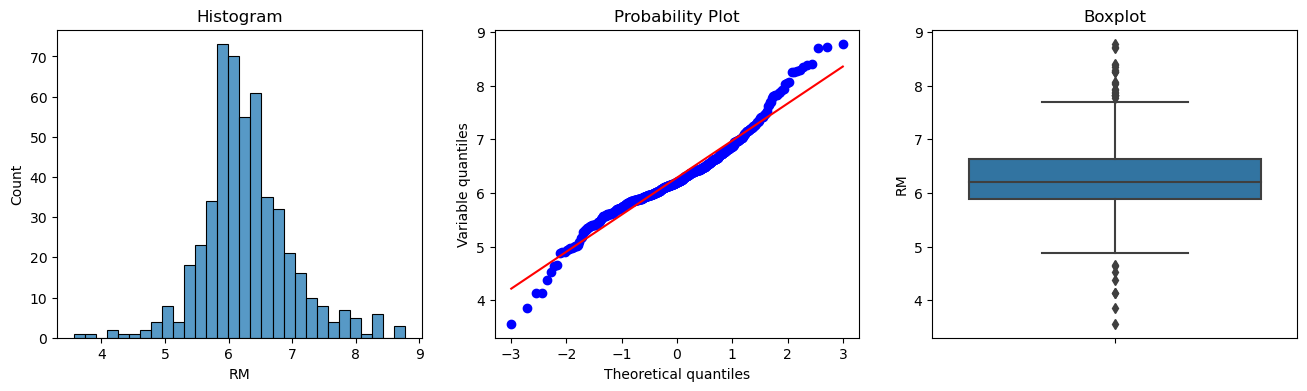

LSTAT


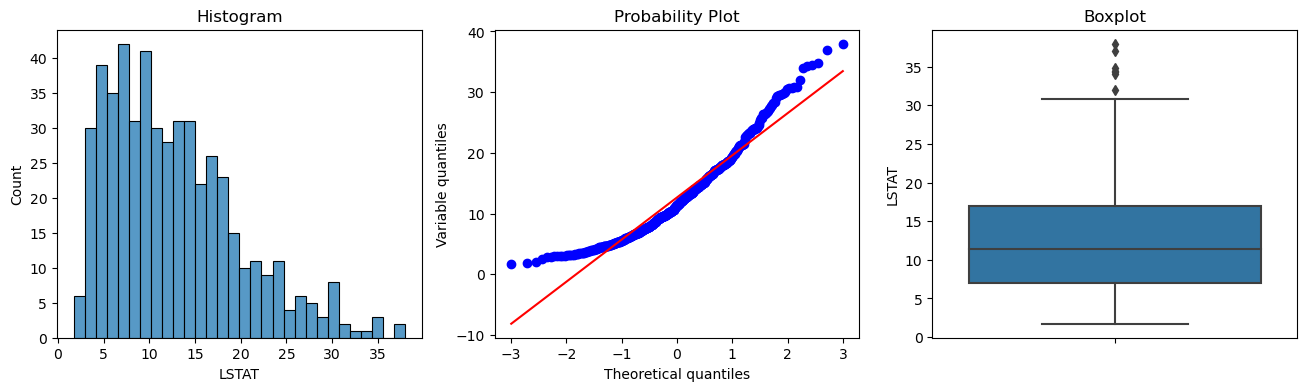

CRIM


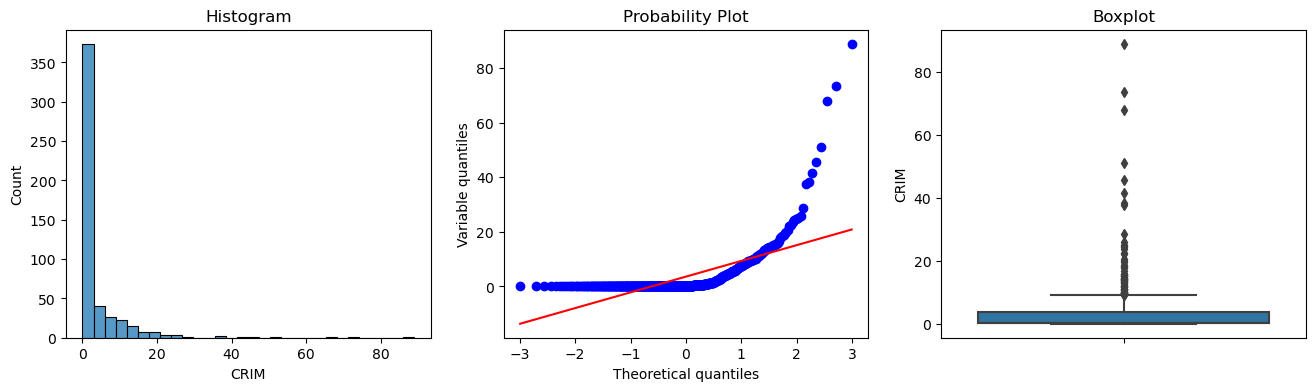

In [6]:
for var in ['RM', 'LSTAT', 'CRIM']:
    diagnostic_plots(boston, var)

There are outliers in all of the above variables. RM shows outliers in both tails, whereas LSTAT and CRIM only on the right tail.

To find the outliers, let's re-utilise the function from variable characteristics.

In [7]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [10]:
# find limits for RM

RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_lower_limit, RM_upper_limit

(4.778499999999999, 7.730500000000001)

In [11]:
# limits for LSTAT

LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_lower_limit, LSTAT_upper_limit

(-8.057500000000005, 31.962500000000006)

In [12]:
# limits for CRIM

CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_lower_limit, CRIM_upper_limit

(-5.31051125, 9.06963875)

In [13]:
# let's flag the outliers in the data set

outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))

In [16]:
# let's flag the outliers in the data set

outliers_LSTAT = np.where(boston['LSTAT'] > LSTAT_upper_limit, True,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, True, False))

In [17]:
# let's flag the outliers in the data set

outliers_CRIM = np.where(boston['CRIM'] > CRIM_upper_limit, True,
                       np.where(boston['CRIM'] < CRIM_lower_limit, True, False))

In [26]:
# let's trimm the dataset

boston_trimmed = boston.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM), ]

boston.shape, boston_trimmed.shape

((506, 3), (416, 3))

We can see that using trimming, we removed almost 100 rows, from a dataset of 500 rows, this is about 20% of the data was removed. This is mostly why, we do not tend to use trimming much in machine learning. But if only a few variables present a tiny proportion of outliers, trimming could work.

RM


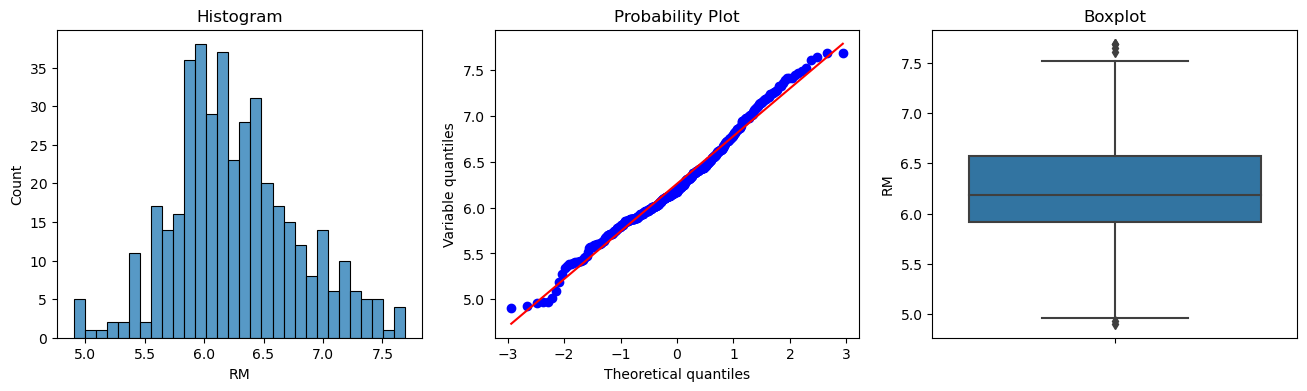

LSTAT


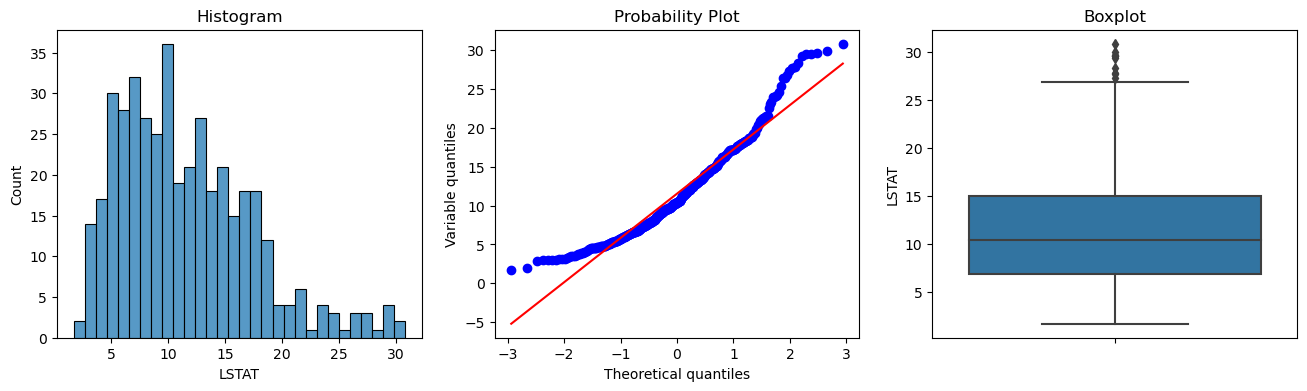

CRIM


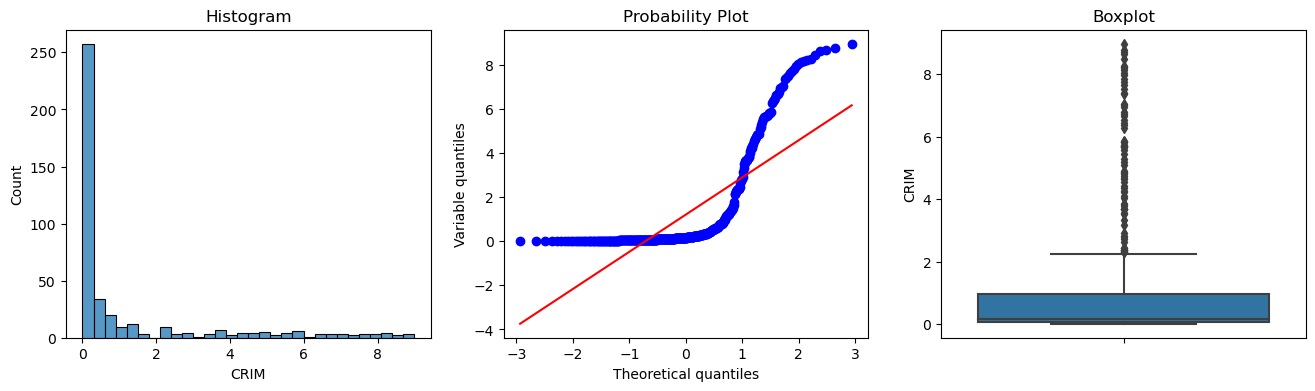

In [27]:
for var in ['RM', 'LSTAT', 'CRIM']:
    diagnostic_plots(boston_trimmed, var)

For LSTAT and CRIM, we still see many outliers. When we remove data points from our dataset, all the parameters of the distribution are re-calculated, those are the mean, quantiles and inter-quantile range, therefore, in the new -trimmed- variable, values that before were not considered outliers, now are.